# Predictor de Flujos de Dinero con XGBoost

## Clasificación de Flujos de Dinero

### 1. INGRESOS
- Cuota mensual de socio: Pago periódico mensual de los socios
- Cuota variable: Pagos de cuota no fija
- Comisión por retirada: Comisiones cobradas por realizar retiros
- Cuota de socio: Pagos de membresía (no mensuales)

### 2. MOVIMIENTOS CIRCUITO
- Recarga por tarjeta: Cuando un usuario ingresa dinero desde su tarjeta bancaria
- Transferencia interna: Movimientos dentro del sistema
- Pago a usuario: Transferencias entre usuarios
- Bonificación por compra: Recompensas otorgadas por compras
- Descuento automático: Cargos automáticos del sistema
- Donación: Transferencias voluntarias a causas o usuarios
- Cobro desde QR: Pagos realizados mediante código QR

### 3. SALIDAS CIRCUITO
- Conversión a €: Operaciones de cambio de moneda
- Retirada a cuenta bancaria: Transferencias hacia cuentas bancarias externas

## Índice
1. Preparación del Entorno
   - Importación de librerías
   - Carga y unión de datos

2. Exploración y Visualización de Datos
   - Análisis de distribución por tipo de flujo
   - Análisis temporal de flujos
     * Patrones mensuales
     * Patrones semanales
     * Patrones diarios por hora

3. Modelado Predictivo con XGBoost
   - Preparación y selección de características
   - División de datos
   - Entrenamiento del modelo
   - Evaluación del modelo

4. Visualización de Resultados
   - Predicciones vs valores reales
   - Análisis de errores
   - Recomendaciones

## 1. Preparación del Entorno

### 1.1 Importación de Librerías
En esta sección importaremos todas las librerías necesarias para:
- Manipulación de datos (pandas, numpy)
- Visualización (matplotlib, seaborn)
- Modelado predictivo (xgboost, sklearn)
- Análisis temporal

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelado
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configuración de visualización
sns.set_theme()  # Tema por defecto de seaborn
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 12

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


### 1.2 Definición de Categorías y Configuración
Definimos las categorías de operaciones y configuramos los colores para la visualización:
- Ingresos (Verde)
- Movimientos Circuito (Azul)
- Salidas Circuito (Rojo)

In [2]:
# Definición de las categorías de operaciones
ingresos = [
    'Cuota mensual de socio',
    'Cuota variable',
    'Comisión por retirada',
    'Cuota de socio'
]

movimientos_circuito = [
    'Transferencia interna',
    'Pago a usuario',
    'Bonificación por compra',
    'Descuento automático',
    'Donación',
    'Cobro desde QR',
    'Recarga por tarjeta'  # Movido de ingresos a movimientos_circuito
]

salidas_circuito = [
    'Conversión a €',
    'Retirada a cuenta bancaria'
]

# Colores para visualización
colores = {
    'Ingresos': '#2ecc71',      # Verde
    'Movimientos': '#3498db',    # Azul
    'Salidas': '#e74c3c'        # Rojo
}

print("Categorías actualizadas correctamente")

Categorías actualizadas correctamente


### 1.3 Carga y Preparación de Datos
En esta sección:
1. Cargamos los datasets necesarios
2. Realizamos las uniones (joins) necesarias
3. Clasificamos las operaciones según las categorías definidas
4. Verificamos la correcta clasificación de todas las operaciones

In [3]:
# Carga de datasets
fact_table = pd.read_csv('csv_base_datos/fact_table.csv', sep=';')
dim_fecha = pd.read_csv('csv_base_datos/dim_fecha.csv', sep=';')
dim_operaciones = pd.read_csv('csv_base_datos/dim_operaciones.csv', sep=';')
dim_direcciones = pd.read_csv('csv_base_datos/dim_direcciones.csv', sep=';')
dim_usuarios = pd.read_csv('csv_base_datos/dim_usuarios.csv', sep=';')

# Unión de tablas
df = fact_table.merge(dim_operaciones, on='Id_tipo_operacion', how='left')
df = df.merge(dim_fecha, on='Id_fecha', how='left')

# Añadir información de usuarios emisores
df = df.merge(dim_usuarios, 
              left_on='Usuario_emisor', 
              right_on='Id_usuario', 
              how='left',
              suffixes=('', '_emisor'))

# Añadir información de usuarios receptores
df = df.merge(dim_usuarios, 
              left_on='Usuario_receptor', 
              right_on='Id_usuario', 
              how='left',
              suffixes=('', '_receptor'))

# Añadir información de direcciones
df = df.merge(dim_direcciones, 
              left_on='Id_direccion', 
              right_on='Id_calle', 
              how='left')

# Clasificación de operaciones
def clasificar_operacion(operacion):
    if operacion in ingresos:
        return 'Ingresos'
    elif operacion in movimientos_circuito:
        return 'Movimientos'
    elif operacion in salidas_circuito:
        return 'Salidas'
    else:
        return 'Otros'

# Añadir clasificación al dataframe
df['Tipo_Flujo'] = df['Operacion'].apply(clasificar_operacion)

# Verificación de la clasificación y datos
print("=== RESUMEN DE OPERACIONES Y DATOS ===")
print("\nDimensiones del DataFrame:", df.shape)
print("\nColumnas disponibles:")
print(df.columns.tolist())

print("\nDistribución por tipo de flujo:")
print(df['Tipo_Flujo'].value_counts())

print("\nOperaciones por categoría:")
for operacion in df['Operacion'].unique():
    tipo = clasificar_operacion(operacion)
    print(f"\n{operacion}: {tipo}")

# Verificar operaciones sin clasificar
operaciones_sin_clasificar = df[df['Tipo_Flujo'] == 'Otros']['Operacion'].unique()
if len(operaciones_sin_clasificar) > 0:
    print("\n¡ADVERTENCIA! Operaciones sin clasificar:")
    print(operaciones_sin_clasificar)

# Verificar valores nulos en columnas importantes
print("\nValores nulos en columnas principales:")
columnas_importantes = ['Cantidad', 'Tipo_Flujo', 'Tipo_usuario', 'Edad', 'Nombre_calle']
print(df[columnas_importantes].isnull().sum())

=== RESUMEN DE OPERACIONES Y DATOS ===

Dimensiones del DataFrame: (340322, 39)

Columnas disponibles:
['Id_transaccion', 'Id_fecha', 'Id_tipo_operacion', 'Cantidad', 'Usuario_emisor', 'Usuario_receptor', 'Hora_transaccion', 'Operacion', 'Fecha', 'Ano', 'Mes', 'Dia', 'DoW', 'Id_usuario', 'NIF/CIF/ID', 'Tipo_usuario', 'Id_fecha_alta', 'Hora_alta', 'Edad', 'Id_direccion', 'CP', 'Capital_social_abonado', 'En_la_asociacion', 'Total_disponible', 'Id_usuario_receptor', 'NIF/CIF/ID_receptor', 'Tipo_usuario_receptor', 'Id_fecha_alta_receptor', 'Hora_alta_receptor', 'Edad_receptor', 'Id_direccion_receptor', 'CP_receptor', 'Capital_social_abonado_receptor', 'En_la_asociacion_receptor', 'Total_disponible_receptor', 'Id_calle', 'Nombre_calle', 'Coordenadas', 'Tipo_Flujo']

Distribución por tipo de flujo:
Tipo_Flujo
Movimientos    330192
Ingresos         9161
Salidas           969
Name: count, dtype: int64

Operaciones por categoría:

Descuento automático: Movimientos

Pago a usuario: Movimientos



## 2. Análisis de Flujos de Dinero

### 2.1 Análisis General de Flujos
Analizaremos la distribución y volumen de los diferentes tipos de flujos:
- Volumen total por tipo de flujo
- Distribución porcentual
- Estadísticas detalladas por categoría

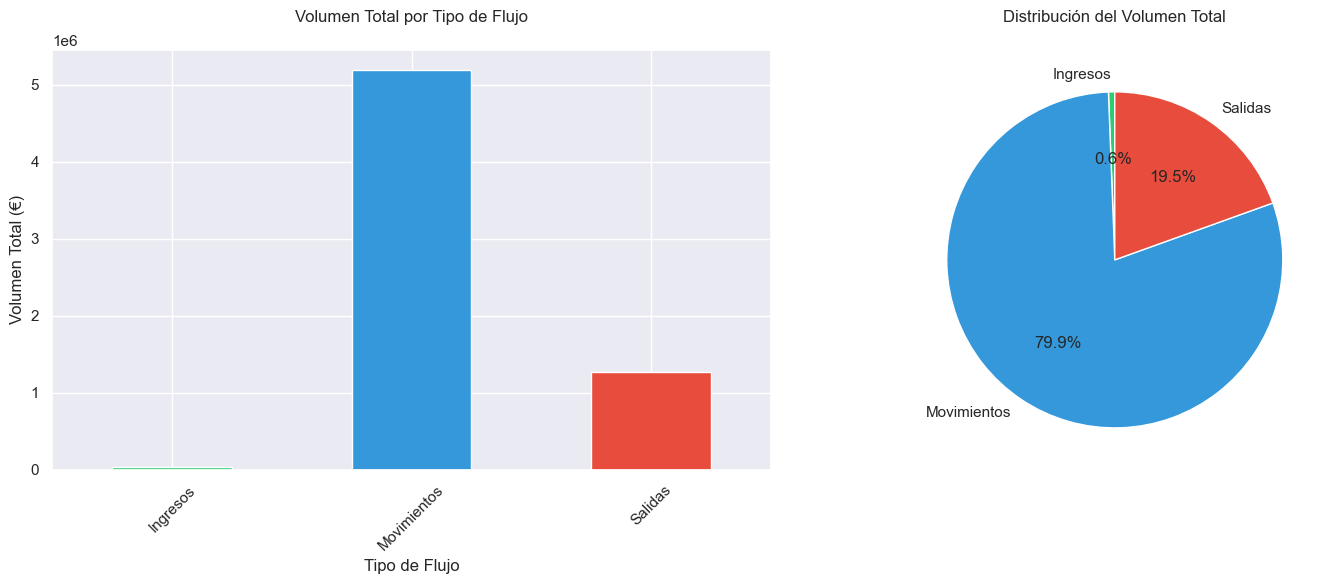


=== ESTADÍSTICAS POR TIPO DE FLUJO ===

Estadísticas generales:


,Num_Operaciones,Volumen_Total,Cantidad_Media,Desv_Estandar
Tipo_Flujo,,,,
Ingresos,9161,39238.07,4.28,8.28
Movimientos,330192,5193306.42,15.73,43.51
Salidas,969,1267647.50,1308.20,1712.78



Detalle por tipo de operación:


Num_Operaciones  Volumen_Total  \
Tipo_Flujo  Operacion                                                 
Ingresos    Comisión por retirada                967       14838.46   
            Cuota de socio                       651        6510.00   
            Cuota mensual de socio              6031       11760.45   
            Cuota variable                      1512        6129.16   
Movimientos Bonificación por compra           100064      153011.49   
            Cobro desde QR                     12894      299646.69   
            Descuento automático               81066       50318.25   
            Donación                           14069        3452.22   
            Pago a usuario                    112779     3430730.90   
            Recarga por tarjeta                 9306     1255837.00   
            Transferencia interna                 14         309.87   
Salidas     Conversión a €                       969     1267647.50   

                                     Cantidad_Media  
Tipo_Flujo  Operacion                                
Ingresos    Comisión por retirada             15.34  
            Cuota de socio                    10.00  
            Cuota mensual de socio             1.95  
            Cuota variable                     4.05  
Movimientos Bonificación por compra            1.53  
            Cobro desde QR                    23.24  
            Descuento automático               0.62  
            Donación                           0.25  
            Pago a usuario                    30.42  
            Recarga por tarjeta              134.95  
            Transferencia interna             22.13  
Salidas     Conversión a €                  1308.20

In [4]:
# === ANÁLISIS DE FLUJOS DE DINERO ===

# 1. Volumen total por tipo de flujo
plt.figure(figsize=(15, 6))

# 1.1 Gráfico de barras
volumen_por_tipo = df.groupby('Tipo_Flujo')['Cantidad'].sum()
colores_grafico = [colores[tipo] for tipo in volumen_por_tipo.index]

plt.subplot(1, 2, 1)
volumen_por_tipo.plot(kind='bar', color=colores_grafico)
plt.title('Volumen Total por Tipo de Flujo', pad=20)
plt.xlabel('Tipo de Flujo')
plt.ylabel('Volumen Total (€)')
plt.xticks(rotation=45)

# 1.2 Gráfico circular
plt.subplot(1, 2, 2)
plt.pie(volumen_por_tipo, labels=volumen_por_tipo.index, colors=colores_grafico,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribución del Volumen Total', pad=20)

plt.tight_layout()
plt.show()

# 2. Estadísticas detalladas
print("\n=== ESTADÍSTICAS POR TIPO DE FLUJO ===")
stats_flujo = df.groupby('Tipo_Flujo').agg({
    'Cantidad': ['count', 'sum', 'mean', 'std']
}).round(2)

# Renombramos las columnas correctamente
stats_flujo.columns = ['Num_Operaciones', 'Volumen_Total', 'Cantidad_Media', 'Desv_Estandar']
print("\nEstadísticas generales:")
display(stats_flujo)

# 3. Detalle por tipo de operación
print("\nDetalle por tipo de operación:")
detalle_operaciones = df.groupby(['Tipo_Flujo', 'Operacion'])['Cantidad'].agg([
    ('Num_Operaciones', 'count'),
    ('Volumen_Total', 'sum'),
    ('Cantidad_Media', 'mean')
]).round(2)

display(detalle_operaciones)

### 2.2 Análisis Temporal
Analizaremos los patrones temporales de los flujos:
- Patrones mensuales
- Patrones por día de la semana
- Patrones por hora del día
- Identificación de horas pico

<Figure size 1500x600 with 0 Axes>

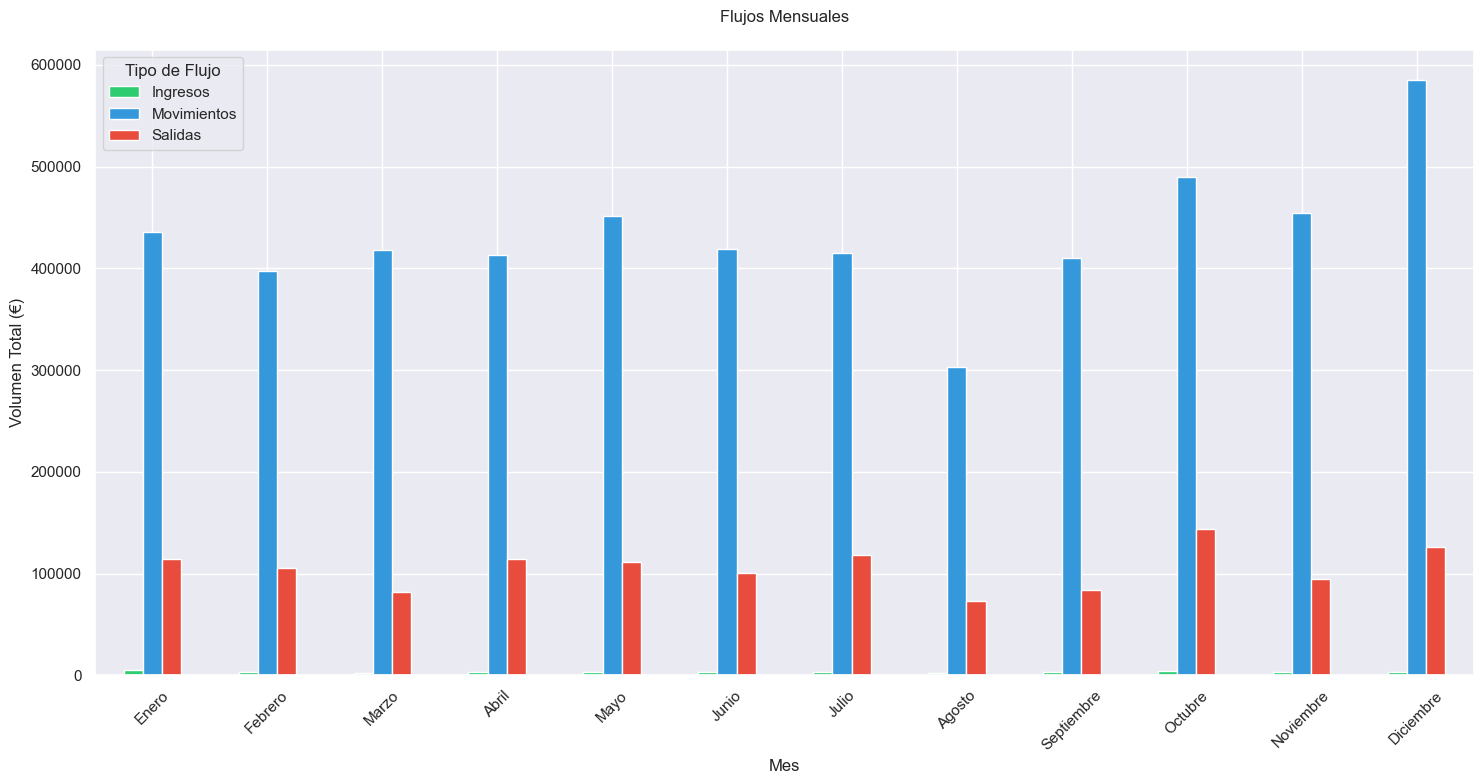

<Figure size 1500x600 with 0 Axes>

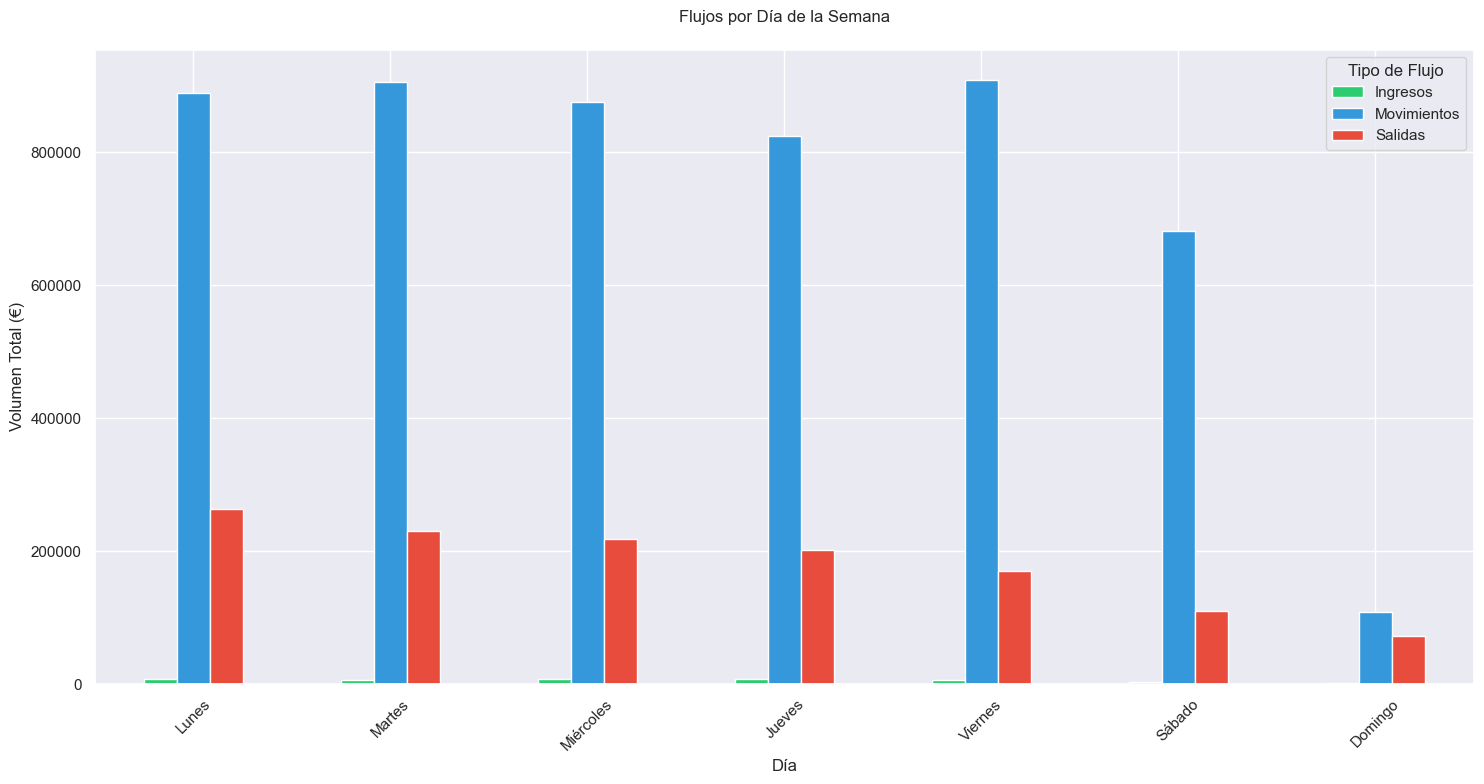

<Figure size 1500x600 with 0 Axes>

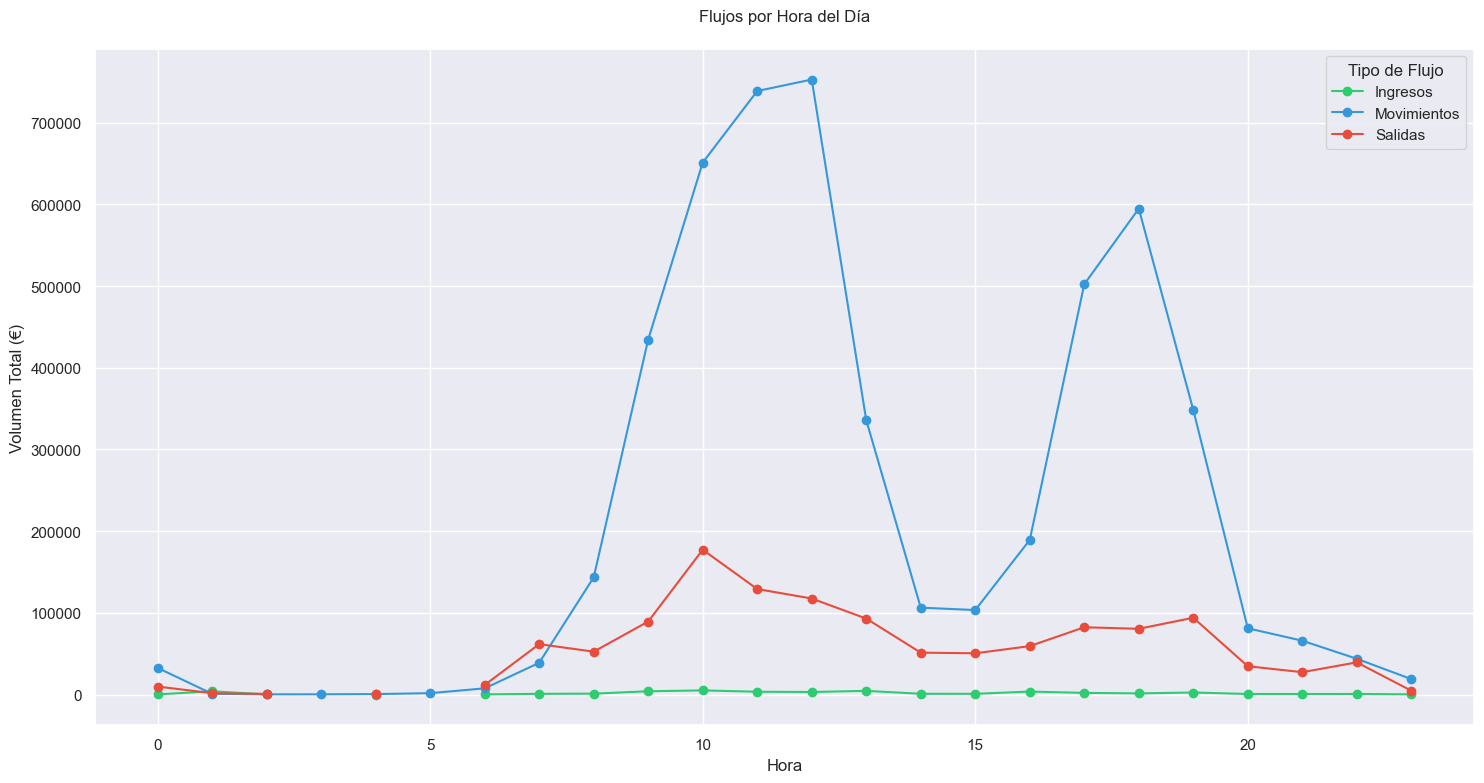


=== ESTADÍSTICAS TEMPORALES ===

Promedios por mes:


Num_Operaciones  Volumen_Total  Promedio_Diario
Nombre_Mes Tipo_Flujo                                                  
Enero      Ingresos                 578        4953.16             8.57
           Movimientos            26101      435612.83            16.69
           Salidas                   72      114229.43          1586.52
Febrero    Ingresos                 641        3180.45             4.96
           Movimientos            27728      397032.78            14.32
           Salidas                   82      105032.99          1280.89
Marzo      Ingresos                 666        2666.05             4.00
           Movimientos            28019      417859.50            14.91
           Salidas                   64       81715.37          1276.80
Abril      Ingresos                 708        3186.38             4.50
           Movimientos            27790      413504.88            14.88
           Salidas                   80      114781.11          1434.76
Mayo       Ingresos                 757        3236.90             4.28
           Movimientos            28638      451522.78            15.77
           Salidas                   86      111650.55          1298.26
Junio      Ingresos                 788        3102.04             3.94
           Movimientos            26474      419439.72            15.84
           Salidas                   82      100858.53          1229.98
Julio      Ingresos                 815        3196.74             3.92
           Movimientos            26919      415368.99            15.43
           Salidas                  105      117773.23          1121.65
Agosto     Ingresos                 787        2633.61             3.35
           Movimientos            21161      303212.84            14.33
           Salidas                   63       73365.84          1164.54
Septiembre Ingresos                 811        2758.83             3.40
           Movimientos            27559      410518.47            14.90
           Salidas                   81       83959.03          1036.53
Octubre    Ingresos                 854        3728.19             4.37
           Movimientos            30367      489318.32            16.11
           Salidas                   97      143881.70          1483.32
Noviembre  Ingresos                 865        3134.93             3.62
           Movimientos            28587      454383.77            15.89
           Salidas                   79       94529.21          1196.57
Diciembre  Ingresos                 891        3460.79             3.88
           Movimientos            30849      585531.54            18.98
           Salidas                   78      125870.51          1613.72


Promedios por día de la semana:


Num_Operaciones  Volumen_Total  Promedio_por_Dia
Nombre_Dia Tipo_Flujo                                                   
Lunes      Ingresos                1581        6989.30              4.42
           Movimientos            55471      888476.45             16.02
           Salidas                  218      263527.05           1208.84
Martes     Ingresos                 873        6103.70              6.99
           Movimientos            60005      905999.88             15.10
           Salidas                  172      230633.97           1340.90
Miércoles  Ingresos                2021        8189.12              4.05
           Movimientos            56728      876175.63             15.45
           Salidas                  160      218428.58           1365.18
Jueves     Ingresos                1908        6880.45              3.61
           Movimientos            51151      824506.31             16.12
           Salidas                  141      201679.75           1430.35
Viernes    Ingresos                1409        6092.23              4.32
           Movimientos            56370      908628.19             16.12
           Salidas                  138      169910.81           1231.24
Sábado     Ingresos                 691        2739.02              3.96
           Movimientos            42818      680955.92             15.90
           Salidas                   78      110586.17           1417.77
Domingo    Ingresos                 678        2244.25              3.31
           Movimientos             7649      108564.04             14.19
           Salidas                   62       72881.17           1175.50


Horas pico por tipo de flujo:
Movimientos: 12:00 hrs (€752,914.50)
Ingresos: 10:00 hrs (€5,021.34)
Salidas: 10:00 hrs (€177,252.59)


In [5]:
# === ANÁLISIS TEMPORAL DE FLUJOS ===

# Mapeo de números a nombres de meses
meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 
         5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto',
         9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

# Añadir nombre del mes al DataFrame
df['Nombre_Mes'] = df['Mes'].map(meses)

# 1. Análisis por mes
plt.figure(figsize=(15, 6))
monthly_flows = df.groupby(['Nombre_Mes', 'Tipo_Flujo'])['Cantidad'].sum().unstack()
# Reordenar los meses
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
monthly_flows = monthly_flows.reindex(orden_meses)

monthly_flows.plot(kind='bar', color=[colores[col] for col in monthly_flows.columns])
plt.title('Flujos Mensuales', pad=20)
plt.xlabel('Mes')
plt.ylabel('Volumen Total (€)')
plt.legend(title='Tipo de Flujo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Análisis por día de la semana
plt.figure(figsize=(15, 6))
# Mapear números a nombres de días
dias = {0:'Lunes', 1:'Martes', 2:'Miércoles', 3:'Jueves', 
        4:'Viernes', 5:'Sábado', 6:'Domingo'}
df['Nombre_Dia'] = df['DoW'].map(dias)

daily_flows = df.groupby(['Nombre_Dia', 'Tipo_Flujo'])['Cantidad'].sum().unstack()
# Reordenar los días
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_flows = daily_flows.reindex(orden_dias)

daily_flows.plot(kind='bar', color=[colores[col] for col in daily_flows.columns])
plt.title('Flujos por Día de la Semana', pad=20)
plt.xlabel('Día')
plt.ylabel('Volumen Total (€)')
plt.legend(title='Tipo de Flujo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Análisis por hora
plt.figure(figsize=(15, 6))
df['Hora'] = pd.to_datetime(df['Hora_transaccion']).dt.hour
hourly_flows = df.groupby(['Hora', 'Tipo_Flujo'])['Cantidad'].sum().unstack()
hourly_flows.plot(kind='line', marker='o', color=[colores[col] for col in hourly_flows.columns])
plt.title('Flujos por Hora del Día', pad=20)
plt.xlabel('Hora')
plt.ylabel('Volumen Total (€)')
plt.legend(title='Tipo de Flujo')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Estadísticas temporales
print("\n=== ESTADÍSTICAS TEMPORALES ===")

print("\nPromedios por mes:")
monthly_stats = df.groupby(['Nombre_Mes', 'Tipo_Flujo'])['Cantidad'].agg([
    ('Num_Operaciones', 'count'),
    ('Volumen_Total', 'sum'),
    ('Promedio_Diario', 'mean')
]).round(2)
# Reordenar los meses en las estadísticas
display(monthly_stats.reindex(orden_meses, level=0))

print("\nPromedios por día de la semana:")
daily_stats = df.groupby(['Nombre_Dia', 'Tipo_Flujo'])['Cantidad'].agg([
    ('Num_Operaciones', 'count'),
    ('Volumen_Total', 'sum'),
    ('Promedio_por_Dia', 'mean')
]).round(2)
display(daily_stats.reindex(orden_dias, level=0))

print("\nHoras pico por tipo de flujo:")
peak_hours = df.groupby(['Tipo_Flujo', 'Hora'])['Cantidad'].sum()
for flujo in df['Tipo_Flujo'].unique():
    hora_pico = peak_hours[flujo].idxmax()
    volumen_pico = peak_hours[flujo].max()
    print(f"{flujo}: {hora_pico}:00 hrs (€{volumen_pico:,.2f})")

### 2.3 Resumen de Hallazgos
Del análisis temporal podemos observar:
- Patrones mensuales de cada tipo de flujo
- Días de la semana con mayor actividad
- Horas pico para cada tipo de operación
- Distribución temporal de los diferentes tipos de flujo

## 3. Análisis de Importancia de Características

En esta sección analizaremos qué factores son más importantes para entender los flujos de dinero utilizando XGBoost.

### Características seleccionadas:

1. **Temporales**:
   - Hora del día
   - Día de la semana
   - Mes
   - Es fin de semana (Sí/No)
   - Es horario comercial (Sí/No)

2. **Usuario**:
   - Tipo de usuario (Empresa/Asociación/Usuario)
   - Edad
   - Capital social

3. **Operacionales**:
   - Tipo de flujo (Ingresos/Movimientos/Salidas)
   - Tipo específico de operación

4. **Ubicación**:
   - Código postal
   - Nombre de calle

### Objetivo del análisis:
Identificar qué factores tienen mayor influencia en los patrones de flujo de dinero para mejorar la predicción y toma de decisiones.

Preparando características...

Entrenando modelo XGBoost...


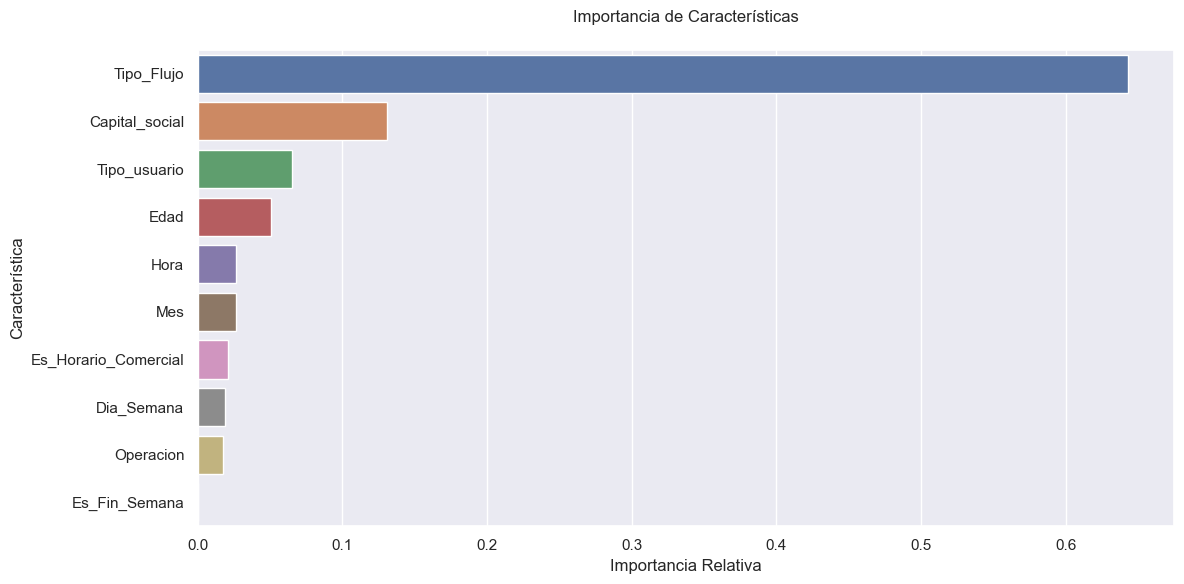


=== RESUMEN DE IMPORTANCIA DE CARACTERÍSTICAS ===

Importancia relativa de cada característica:


,Característica,Importancia
8,Tipo_Flujo,0.64
7,Capital_social,0.13
5,Tipo_usuario,0.06
6,Edad,0.05
0,Hora,0.03
2,Mes,0.03
4,Es_Horario_Comercial,0.02
1,Dia_Semana,0.02
9,Operacion,0.02
3,Es_Fin_Semana,0.00



Porcentaje de importancia de cada característica:
Tipo_Flujo: 64.26000213623047%
Capital_social: 13.09000015258789%
Tipo_usuario: 6.5%
Edad: 5.079999923706055%
Hora: 2.6700000762939453%
Mes: 2.630000114440918%
Es_Horario_Comercial: 2.119999885559082%
Dia_Semana: 1.9199999570846558%
Operacion: 1.7300000190734863%
Es_Fin_Semana: 0.0%


In [6]:
# === ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS CON XGBOOST ===

# 1. Preparación de características
print("Preparando características...")

# Características temporales
df['Hora'] = pd.to_datetime(df['Hora_transaccion']).dt.hour
df['Es_Fin_Semana'] = df['DoW'].isin([5,6]).astype(int)
df['Es_Horario_Comercial'] = df['Hora'].between(9, 18).astype(int)

# Selección y preparación de características
features = pd.DataFrame()

# Características temporales
features['Hora'] = df['Hora']
features['Dia_Semana'] = df['DoW']
features['Mes'] = df['Mes']
features['Es_Fin_Semana'] = df['Es_Fin_Semana']
features['Es_Horario_Comercial'] = df['Es_Horario_Comercial']

# Características de usuario y operación
features['Tipo_usuario'] = pd.Categorical(df['Tipo_usuario']).codes
features['Edad'] = df['Edad']
features['Capital_social'] = pd.Categorical(df['Capital_social_abonado']).codes
features['Tipo_Flujo'] = pd.Categorical(df['Tipo_Flujo']).codes
features['Operacion'] = pd.Categorical(df['Operacion']).codes

# Variable objetivo
y = df['Cantidad']

# 2. Entrenamiento del modelo
print("\nEntrenando modelo XGBoost...")
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(features, y)

# 3. Análisis de importancia de características
importance_df = pd.DataFrame({
    'Característica': features.columns,
    'Importancia': model.feature_importances_
})
importance_df = importance_df.sort_values('Importancia', ascending=False)

# 4. Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Importancia', y='Característica')
plt.title('Importancia de Características', pad=20)
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()

# 5. Resumen detallado
print("\n=== RESUMEN DE IMPORTANCIA DE CARACTERÍSTICAS ===")
print("\nImportancia relativa de cada característica:")
display(importance_df)

# 6. Porcentajes de importancia
importance_df['Porcentaje'] = (importance_df['Importancia'] * 100).round(2)
print("\nPorcentaje de importancia de cada característica:")
for idx, row in importance_df.iterrows():
    print(f"{row['Característica']}: {row['Porcentaje']}%")

## 4. Predicción de Ingresos con XGBoost

Desarrollaremos un modelo para predecir los ingresos futuros basándonos en los patrones históricos.

### Objetivo:
Predecir el volumen de ingresos (cuotas de socios, comisiones, etc.) para mejorar la planificación financiera.

### Proceso:
1. Preparación de datos
   - Filtrado de operaciones de ingreso
   - Agregación temporal de ingresos
   - Creación de características predictivas

2. Modelado
   - Entrenamiento con datos históricos
   - Predicción de ingresos futuros
   - Validación del modelo

3. Evaluación
   - Análisis de precisión por tipo de ingreso
   - Visualización de predicciones
   - Identificación de patrones

Preparando datos para predicción de ingresos...

=== VALIDACIÓN CRUZADA ===

Resultados de Cross-Validation:
r2: 0.9542 (+/- 0.1462)
rmse: 17.8665 (+/- 30.2213)
mae: 4.8322 (+/- 3.8783)

Entrenando modelo final...

=== MÉTRICAS DETALLADAS ===

Métricas en Training:
R2: 0.9992
RMSE: 3.3680
MAE: 1.9170
MAPE: 83.9506
Error_Medio: -0.0009
Error_Std: 3.3680

Métricas en Test:
R2: 0.9877
RMSE: 9.8407
MAE: 3.8644
MAPE: 24.1860
Error_Medio: 0.6368
Error_Std: 9.8201


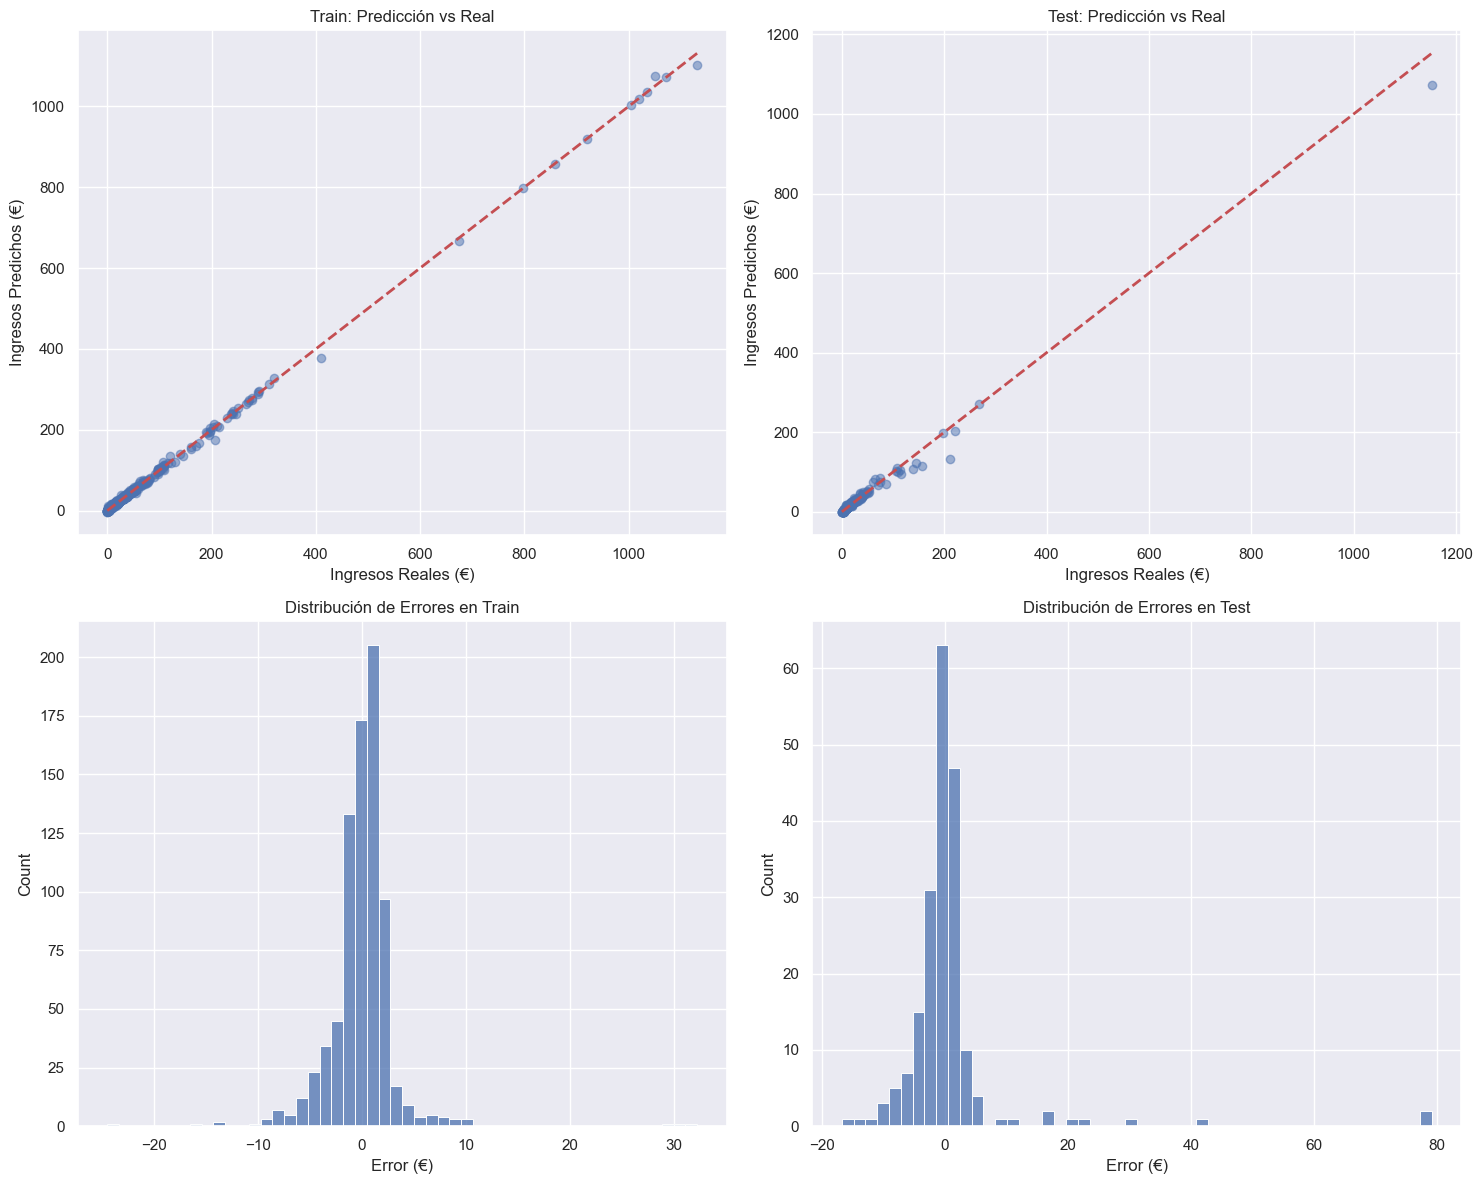

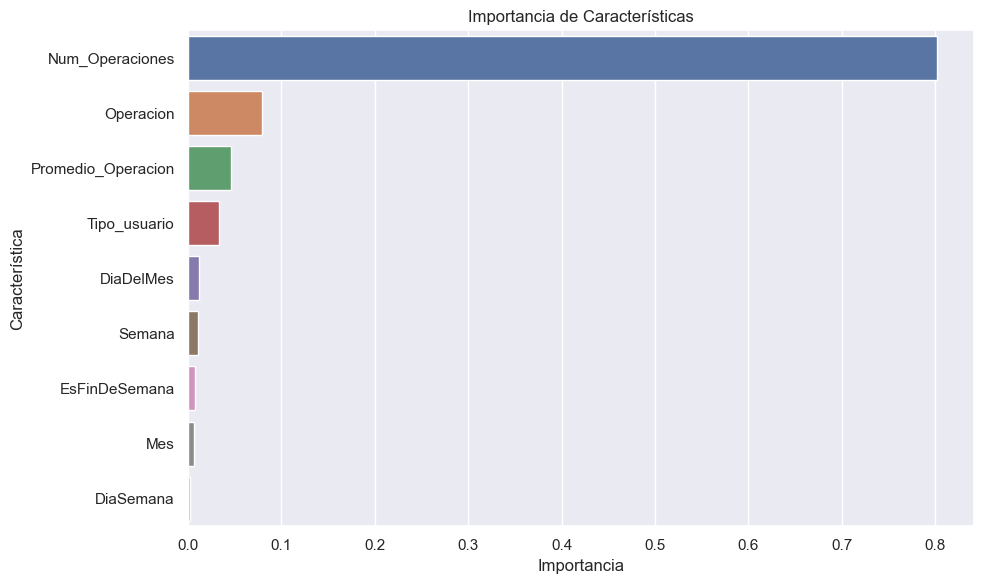

In [7]:
# === PREDICCIÓN DE INGRESOS CON XGBOOST Y VALIDACIÓN CRUZADA ===

# 1. Preparación de datos
print("Preparando datos para predicción de ingresos...")

# Filtrar solo operaciones de ingreso
df_ingresos = df[df['Tipo_Flujo'] == 'Ingresos'].copy()

# Agregación diaria de ingresos por tipo de operación
ingresos_diarios = df_ingresos.groupby(['Fecha', 'Operacion', 'Tipo_usuario'])['Cantidad'].agg([
    'sum',    # suma total
    'count',  # número de operaciones
    'mean'    # promedio por operación
]).reset_index()

ingresos_diarios['Fecha'] = pd.to_datetime(ingresos_diarios['Fecha'])

# Crear características mejoradas
X_ingresos = pd.DataFrame()

# Características temporales
X_ingresos['Mes'] = ingresos_diarios['Fecha'].dt.month
X_ingresos['DiaSemana'] = ingresos_diarios['Fecha'].dt.dayofweek
X_ingresos['DiaDelMes'] = ingresos_diarios['Fecha'].dt.day
X_ingresos['EsFinDeSemana'] = X_ingresos['DiaSemana'].isin([5,6]).astype(int)
X_ingresos['Semana'] = ingresos_diarios['Fecha'].dt.isocalendar().week

# Codificar variables categóricas
X_ingresos['Operacion'] = pd.Categorical(ingresos_diarios['Operacion']).codes
X_ingresos['Tipo_usuario'] = pd.Categorical(ingresos_diarios['Tipo_usuario']).codes

# Características de volumen
X_ingresos['Num_Operaciones'] = ingresos_diarios['count']
X_ingresos['Promedio_Operacion'] = ingresos_diarios['mean']

# Variable objetivo
y_ingresos = ingresos_diarios['sum']

# 2. Cross-Validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("\n=== VALIDACIÓN CRUZADA ===")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir métricas
scoring = {
    'r2': 'r2',
    'neg_rmse': make_scorer(lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred))),
    'neg_mae': 'neg_mean_absolute_error'
}

# Modelo base
model_ingresos = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Realizar cross-validation con múltiples métricas
cv_results = {}
for metric_name, scorer in scoring.items():
    scores = cross_val_score(model_ingresos, X_ingresos, y_ingresos, 
                           cv=kfold, scoring=scorer)
    cv_results[metric_name] = scores

print("\nResultados de Cross-Validation:")
for metric, scores in cv_results.items():
    if 'neg_' in metric:
        scores = -scores  # Convertir métricas negativas a positivas
    print(f"{metric.replace('neg_', '')}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# 3. Entrenamiento final y evaluación detallada
# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_ingresos, y_ingresos, test_size=0.2, random_state=42
)

# Entrenamiento
print("\nEntrenando modelo final...")
model_ingresos.fit(X_train, y_train)

# Predicciones para train y test
y_pred_train = model_ingresos.predict(X_train)
y_pred_test = model_ingresos.predict(X_test)

# Función para calcular métricas
def calcular_metricas(y_true, y_pred, prefix=""):
    return {
        f'{prefix}R2': r2_score(y_true, y_pred),
        f'{prefix}RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        f'{prefix}MAE': mean_absolute_error(y_true, y_pred),
        f'{prefix}MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        f'{prefix}Error_Medio': np.mean(y_true - y_pred),
        f'{prefix}Error_Std': np.std(y_true - y_pred)
    }

# Calcular métricas para train y test
metricas_train = calcular_metricas(y_train, y_pred_train, "Train_")
metricas_test = calcular_metricas(y_test, y_pred_test, "Test_")

print("\n=== MÉTRICAS DETALLADAS ===")
print("\nMétricas en Training:")
for metric, value in metricas_train.items():
    print(f"{metric.replace('Train_', '')}: {value:.4f}")

print("\nMétricas en Test:")
for metric, value in metricas_test.items():
    print(f"{metric.replace('Test_', '')}: {value:.4f}")

# 4. Visualización de resultados
plt.figure(figsize=(15, 12))

# Predicciones vs Reales en Train
plt.subplot(2, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Ingresos Reales (€)')
plt.ylabel('Ingresos Predichos (€)')
plt.title('Train: Predicción vs Real')

# Predicciones vs Reales en Test
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Ingresos Reales (€)')
plt.ylabel('Ingresos Predichos (€)')
plt.title('Test: Predicción vs Real')

# Distribución de errores en Train
plt.subplot(2, 2, 3)
sns.histplot(y_train - y_pred_train, bins=50)
plt.title('Distribución de Errores en Train')
plt.xlabel('Error (€)')

# Distribución de errores en Test
plt.subplot(2, 2, 4)
sns.histplot(y_test - y_pred_test, bins=50)
plt.title('Distribución de Errores en Test')
plt.xlabel('Error (€)')

plt.tight_layout()
plt.show()

# 5. Importancia de características
importancia = pd.DataFrame({
    'Característica': X_ingresos.columns,
    'Importancia': model_ingresos.feature_importances_
})
importancia = importancia.sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia, x='Importancia', y='Característica')
plt.title('Importancia de Características')
plt.tight_layout()
plt.show()

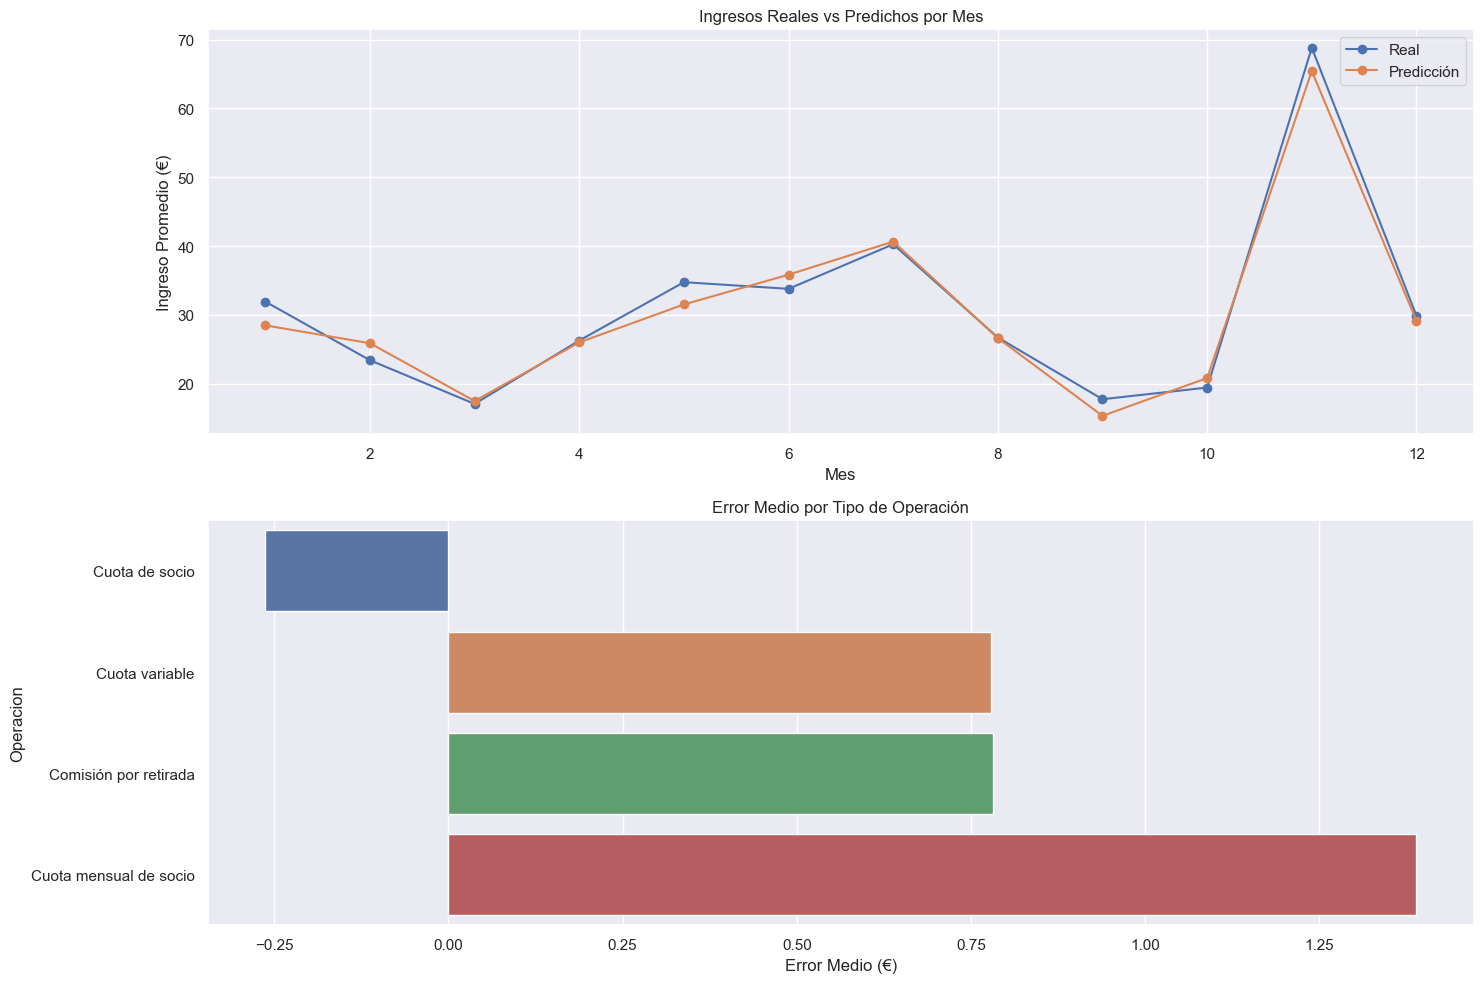


=== ANÁLISIS DETALLADO DE PREDICCIONES ===

Estadísticas por tipo de operación:


,Num_Operaciones,Ingreso_Real_Medio,Prediccion_Media,Error_Medio,Desv_Error
Operacion,,,,,
Comisión por retirada,114,30.17,29.39,0.78,10.31
Cuota de socio,46,15.87,16.13,-0.26,1.36
Cuota mensual de socio,32,43.81,42.42,1.39,14.61
Cuota variable,6,133.23,132.45,0.78,8.07



Estadísticas por día de la semana:


,Num_Operaciones,Ingreso_Medio,Error_Medio,Desv_Error
NombreDia,,,,
Domingo,15,11.79,-0.33,3.35
Jueves,34,59.43,4.05,19.41
Lunes,35,33.81,1.13,9.38
Martes,39,27.71,0.34,5.51
Miércoles,33,30.79,-1.44,5.64
Sábado,19,26.00,-0.07,5.55
Viernes,23,17.39,-0.47,2.86


In [8]:
# === ANÁLISIS DETALLADO DE PREDICCIONES DE INGRESOS ===

# 1. Análisis temporal de predicciones
ingresos_test = ingresos_diarios.iloc[y_test.index].copy()
ingresos_test['Prediccion'] = y_pred_test
ingresos_test['Error'] = ingresos_test['sum'] - y_pred_test
ingresos_test['Mes'] = ingresos_test['Fecha'].dt.month

# Visualización temporal
plt.figure(figsize=(15, 10))

# Predicciones vs Reales por mes
plt.subplot(2, 1, 1)
predicciones_mes = ingresos_test.groupby('Mes').agg({
    'sum': 'mean',
    'Prediccion': 'mean'
}).reset_index()

plt.plot(predicciones_mes['Mes'], predicciones_mes['sum'], 'o-', label='Real')
plt.plot(predicciones_mes['Mes'], predicciones_mes['Prediccion'], 'o-', label='Predicción')
plt.title('Ingresos Reales vs Predichos por Mes')
plt.xlabel('Mes')
plt.ylabel('Ingreso Promedio (€)')
plt.legend()

# Error por tipo de operación
plt.subplot(2, 1, 2)
error_operacion = ingresos_test.groupby('Operacion')['Error'].mean().sort_values()
sns.barplot(x=error_operacion.values, y=error_operacion.index)
plt.title('Error Medio por Tipo de Operación')
plt.xlabel('Error Medio (€)')

plt.tight_layout()
plt.show()

# 2. Estadísticas detalladas
print("\n=== ANÁLISIS DETALLADO DE PREDICCIONES ===")

# Por tipo de operación
print("\nEstadísticas por tipo de operación:")
stats_operacion = ingresos_test.groupby('Operacion').agg({
    'sum': ['count', 'mean'],
    'Prediccion': 'mean',
    'Error': ['mean', 'std']
}).round(2)
stats_operacion.columns = ['Num_Operaciones', 'Ingreso_Real_Medio', 'Prediccion_Media', 'Error_Medio', 'Desv_Error']
display(stats_operacion)

# Por día de la semana
print("\nEstadísticas por día de la semana:")
ingresos_test['DiaSemana'] = ingresos_test['Fecha'].dt.dayofweek
dias = {0:'Lunes', 1:'Martes', 2:'Miércoles', 3:'Jueves', 
        4:'Viernes', 5:'Sábado', 6:'Domingo'}
ingresos_test['NombreDia'] = ingresos_test['DiaSemana'].map(dias)

stats_dia = ingresos_test.groupby('NombreDia').agg({
    'sum': ['count', 'mean'],
    'Error': ['mean', 'std']
}).round(2)
stats_dia.columns = ['Num_Operaciones', 'Ingreso_Medio', 'Error_Medio', 'Desv_Error']
display(stats_dia)

In [9]:
# === GUARDAR MODELO ENTRENADO ===
import pickle

print("Guardando modelo y características...")

# Guardar el modelo
with open('modelo_ingresos_xgboost.pkl', 'wb') as file:
    pickle.dump(model_ingresos, file)

# Guardar también las características y su orden para asegurar consistencia
caracteristicas = {
    'columnas': X_ingresos.columns.tolist(),
    'categorias_operacion': ingresos_diarios['Operacion'].unique().tolist(),
    'categorias_tipo_usuario': ingresos_diarios['Tipo_usuario'].unique().tolist()
}

with open('caracteristicas_modelo.pkl', 'wb') as file:
    pickle.dump(caracteristicas, file)

print("Modelo y características guardados correctamente")

Guardando modelo y características...
Modelo y características guardados correctamente
